In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import scipy
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *
from diffusion import Diffusion
from model import Unet, get_num_trainable_params
# import math

In [2]:
class Config:
    img_size = 64
    batch_size = 32
    T = 500
    sample_T = 15000
    device = "cpu"
    lr = 0.001
    time_embd_dim = 32
    steps = 200
    max_iters = steps * (16000 // batch_size) # num iterations through all batches in dataset (total imgs ~ 16k) 

config = Config()

(32, 500, 100000, 'cpu')

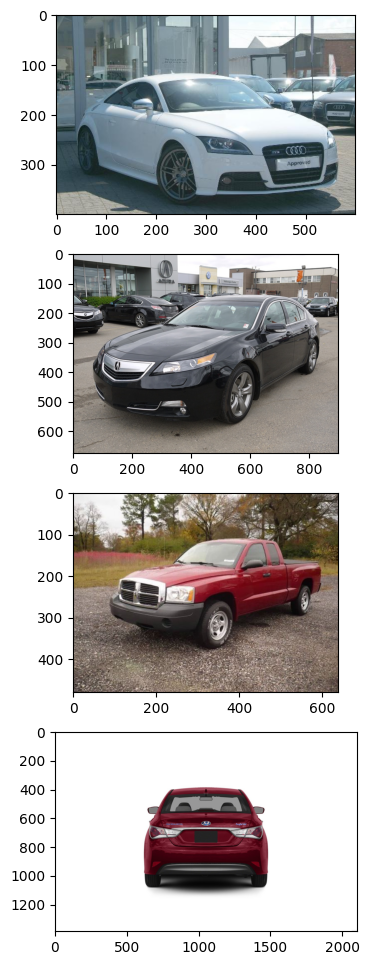

In [3]:
data_root_dir = "../data"
dataset = torchvision.datasets.StanfordCars(data_root_dir)
show_images(dataset, num_samples=4, cols=1)

In [4]:
data = load_transformed_dataset(config.img_size, data_root_dir)
# tiny_data = torch.utils.data.Subset(data, range(8))
train_dataloader = DataLoader(data, batch_size=config.batch_size, shuffle=True, drop_last=False)

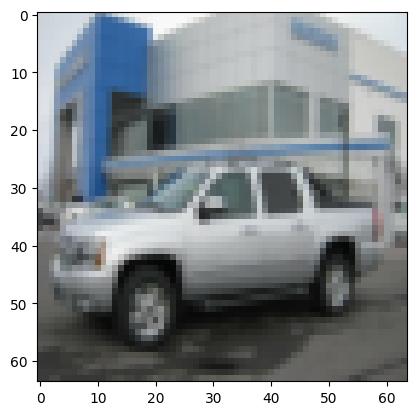

In [5]:
img1 = next(iter(train_dataloader))[0]
show_tensor_image(img1)

In [9]:
model = Unet(time_embd_dim=config.time_embd_dim)
model.to(config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)

In [10]:
ckpt_path = "unet_diffusion_v1_ep40000.pt"
checkpoint = torch.load(ckpt_path, map_location=config.device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
print(f"\nCheckpoint loaded from path --> {ckpt_path}\n")


Checkpoint loaded from path --> unet_diffusion_v1_ep40000.pt



In [11]:
get_num_trainable_params(model)

22790115

In [12]:
diff = Diffusion(timesteps=config.T, img_size=config.img_size, device=config.device)

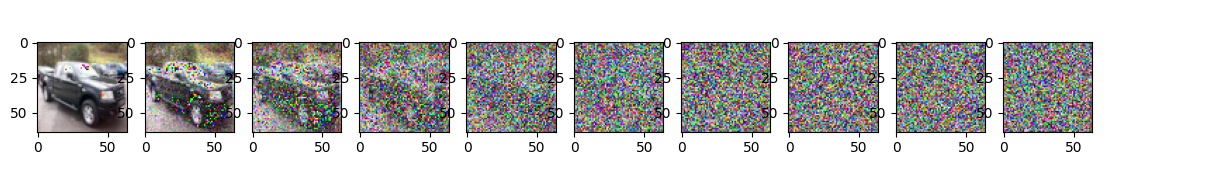

In [15]:
# Simulate forward diffusion
image = next(iter(train_dataloader))[0]
diff.vis_forward_diffusion(image)

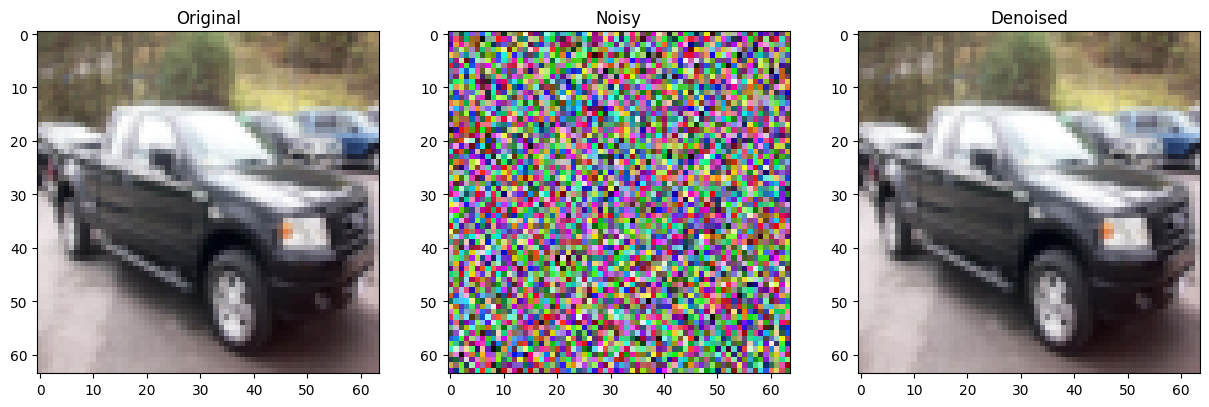

In [17]:
# Simulate & test reverse diffusion
t_test = torch.full((1,), 400, device="cpu", dtype=torch.long)
diff.test_reverse_diffusion(t_test, image)

In [18]:
def get_batch(dataloader):
    return next(iter(dataloader))

def get_loss(model, x_0, t):
    mse = nn.MSELoss()
    x_noisy, noise = diff.forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return mse(noise, noise_pred)


def save_checkpoint(path, itr, loss):
    torch.save({
        "model": model.state_dict(),
        "config": config,
        "optimizer": optimizer.state_dict(),
        "epoch": itr,
        "loss": loss,
    }, path)
    print(f"Model saved to {path}")

def train(model, optimizer, dataloader, iters, T, batch_size=config.batch_size, diffusion=None):
    losses = []
    for itr in tqdm(range(iters)):
        optimizer.zero_grad()
        t = torch.randint(0, T, (batch_size,), device=config.device).long()
        x_0 = get_batch(dataloader)[0]
        loss = get_loss(model, x_0, t)
        loss.backward()
        optimizer.step()
        
        if itr % (iters // 5) == 0 or itr == iters - 1:
            path = f"unet_diffusion_v2_ep{itr}.pt"
            save_checkpoint(path, itr, loss.item())
        
        if itr % (iters // 50)  == 0:
            print(f"Epoch {itr} | Loss: {loss.item()} ")
            losses.append(loss.item())
        
        if (itr % (iters // 10) == 0) or itr == iters - 1 :
            diff.sample_plot_image(model)
              
    return losses

In [1]:
losses = train(model=model, optimizer=optimizer, dataloader=train_dataloader, 
                   iters=config.max_iters, T=config.T, batch_size=config.batch_size)

In [2]:
# plt.plot(losses)

In [21]:
diff2 = Diffusion(timesteps=config.sample_T)

100%|██████████| 60000/60000 [08:22<00:00, 119.44it/s]


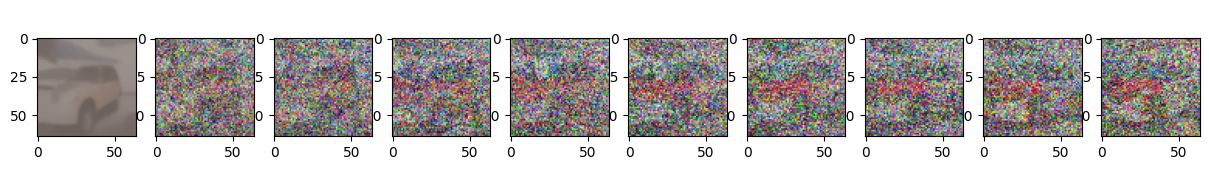

In [22]:
num_samples = 10
with torch.no_grad():
    for i in range(num_samples):
        img_size = config.img_size
        img = torch.randn((1, 3, img_size, img_size), device=config.device)
        plt.figure(figsize=(15,2))
        plt.axis('off')
        num_images = 10
        stepsize = int(config.sample_T/num_images)
        
        for i in tqdm(range(0,config.sample_T)[::-1]):
            t = torch.full((1,), i, device=config.device, dtype=torch.long)
            img = diff2.sample_timestep(model, img, t)
            img = torch.clamp(img, -1.0, 1.0)
            if i % stepsize == 0:
                plt.subplot(1, num_images, int(i/stepsize)+1)
                show_tensor_image(img.detach().cpu())
        plt.show()

In [ ]:
# torch.cuda.empty_cache()